In [8]:
import torch
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, Subset, random_split, ConcatDataset
import numpy as np
from torch import nn, optim
import os
from sklearn.utils import shuffle
from itertools import combinations
from time import time

from torch.autograd import grad
from inverse_hvp import get_inverse_hvp

import matplotlib.pyplot as plt
%matplotlib inline

# Directories & File names

DATA_DIR = "./data"
MODEL_DIR = "./model"

# Hyperparameters

NUM_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.01
SEED = 1234
NFOLD = 5

# IF computation hyperparameters

TEST_SUBSET_SIZE = 100
LISSA_PARAMS = {
    "batch_size": 10,
    "num_repeats": 10,
    "recursion_depth": 500,
    "scale":1,
}
NUM_SPLITS = 6

In [2]:
# Load & Preprocess Data

def load_MNIST(data_dir):
    """
    Returns MNIST training & test datasets modified so that
    data points corresponding to only two specified labels remain.
    
    :data_dir: directory to download the MNIST data files
    :returns: a tuple of two `torch.utils.data.Dataset` instances
                corresponding to training and test datasets
    """
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    mnist_train = MNIST(data_dir, train=True, download=True, transform=ToTensor())
    mnist_test = MNIST(data_dir, train=False, download=True, transform=ToTensor())
    
    return mnist_train, mnist_test


def preproc_MNIST(inputs, targets):
    """Modifies minibatch to suit for training MNIST classifier.

    :inputs, targets: the minibatch to be preprocessed
    :returns: the preprocessed versions of `inputs`, `targets`
    """
    inputs = inputs.reshape(-1, 28*28).float()
    return inputs, targets


def balanced_kfold(dataset, nfold=5, size_per_class=None, seed=None):
    class_sizes = torch.tensor([torch.sum(dataset.targets == label) for label in range(10)])
    assert size_per_class is None or size_per_class <= torch.min(class_sizes), \
        "ERROR: One or more classes have less data points than specified `size_per_class`"
    if size_per_class is None:
        size_per_class = torch.min(class_sizes).item()
        
    # Make sizes be multiples of `nfold`
    size_per_class = size_per_class // nfold * nfold
        
    extracted = []
    for label in range(10):
        sampled_idxs = np.random.choice(class_sizes[label].item(),
                                                               size=size_per_class, replace=False)
        sampled_idxs =  (mnist_train.targets == label).nonzero().flatten().numpy()[sampled_idxs]
        extracted.append([dataset.data[sampled_idxs], dataset.targets[sampled_idxs]])
        
    size_of_class_per_fold = size_per_class // nfold
    
    data_folds = [ torch.cat([data[fold*size_of_class_per_fold:(fold+1)*size_of_class_per_fold]
                            for data, _ in extracted]) for fold in range(nfold)]
    targets_folds = [ torch.cat([targets[fold*size_of_class_per_fold:(fold+1)*size_of_class_per_fold]
                            for _, targets in extracted]) for fold in range(nfold)]
    
    for fold in range(nfold):
        shuffle_idxs = shuffle(np.arange(size_of_class_per_fold * 10),
                                           random_state=seed)
        data_folds[fold] = data_folds[fold][shuffle_idxs]
        targets_folds[fold] = targets_folds[fold][shuffle_idxs]
    
    return data_folds, targets_folds

mnist_train, mnist_test = load_MNIST(DATA_DIR)
data_folds, target_folds = balanced_kfold(mnist_train, nfold=NFOLD, size_per_class=5000)

In [3]:
class KFoldDataset(Dataset):
    def __init__(self, data_folds, targets_folds, to_include):
        assert np.max(to_include) < len(data_folds), \
            "ERROR: Cannot include fold with larger index than " \
            "the total number of folds"
        
        self.data = torch.cat([data_folds[idx] for idx in to_include])
        self.targets = torch.cat([targets_folds[idx] for idx in to_include])
        
    def __len__(self):
        return self.targets.shape[0]
    
    def __getitem__(self, index):
        return self.data[index], self.targets[index]

In [4]:
def train_model(model, train_loader, test_loader,
                           num_epochs=NUM_EPOCHS,
                           batch_size=BATCH_SIZE,
                           learning_rate=LEARNING_RATE,
                           preproc_fn=preproc_MNIST,
                           verbose=True):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        total_train_loss = 0
        count_correct = 0
        count_total = 0

        for input, target in train_loader:
            optimizer.zero_grad()

            input, target = preproc_fn(input, target)

            logits = model(input)
            loss = criterion(logits, target)

            count_correct += torch.sum(torch.argmax(logits, dim=1) == target)

            total_train_loss += loss.item() * target.shape[0]
            loss.backward()
            optimizer.step()
        else:    # Test training progress with test dataset
            count_total = len(train_loader) * batch_size
            if verbose:
                print(f"Epoch {epoch+1}) Average train loss = {total_train_loss / count_total:.4f}, "
                         f"train acccuracy = {float(count_correct) / count_total:.4f}")

            total_test_loss = 0
            count_correct = 0
            for input, target in test_loader:
                input, target = preproc_fn(input, target)

                count_total += target.shape[0]

                logits = model(input)
                loss = criterion(logits, target)

                count_correct += torch.sum(torch.argmax(logits, dim=1) == target)
                total_test_loss += loss.item() * target.shape[0]
            else:
                count_total = len(test_loader) * batch_size
                if verbose:
                    print(f"\t\tAverage test loss = {total_test_loss / count_total:.4f}, "
                             f"test acccuracy = {float(count_correct) / count_total:.4f}")
                
    if verbose:
        print(">>> Model training complete")
    return model

In [5]:
# Influence function of loss w.r.t. upweighting
def compute_IF(model,
                          train_dataset,
                          test_dataset,
                          preproc_fn=preproc_MNIST,
                          approx_type='lissa',
                          lissa_params=LISSA_PARAMS,
                          verbose=True):
    if verbose:
        print(">>> Begin computing IF values")
    
    params = list(model.parameters())
    criterion = nn.CrossEntropyLoss()

    # Compute gradients w.r.t. each training data point
    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
    train_grads = []
    for idx, (input, target) in enumerate(train_loader):
        input, target = preproc_fn(input, target)
        loss = criterion(model(input), target)
        grads = grad(loss, params)
        train_grads.append(grads)
        
    if verbose:
        print(">>> `train_grads` computed")

    # Compute `s_test` values w.r.t. each test data point
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
    s_test_values = []
    for s_test_idx, (input, target) in enumerate(test_loader):
        if verbose:
            start_time = time()
        
        input, target = preproc_fn(input, target)
        loss = criterion(model(input), target)
        test_grads = grad(loss, params)

        s_test = get_inverse_hvp(model, criterion, train_dataset, test_grads,
                                                approx_type='lissa',
                                                approx_params=lissa_params,
                                                preproc_data_fn=preproc_fn)
        s_test_values.append(s_test)
        
        if verbose and (s_test_idx+1) % 10 == 0:
            print(f">>> Completed {s_test_idx+1}/{len(test_loader)} test point, "
                     f"duration per point: {time() - start_time:.2f} seconds")
        
    if verbose:
        print(">>> `s_test_values` computed")

    # Compute influence for each (train,test) pair and
    # store w.r.t. each test point
    IF_values = []
    for s_test_idx, s_test in enumerate(s_test_values):
            
        inf_up_loss = []
        for train_grad in train_grads:
            inf = 0
            for train_grad_p, s_test_p in zip(train_grad, s_test):
                assert train_grad_p.shape == s_test_p.shape
                inf += -torch.sum(train_grad_p * s_test_p)    # Parameter-wise dot product accumulation
            inf_up_loss.append(inf)
        IF_values.append(inf_up_loss)
        
        if verbose and (s_test_idx+1) % 10 == 0:
            print(f">>> Completed {s_test_idx+1}th test point")

    return torch.tensor(IF_values)

In [6]:
def main():
    torch.manual_seed(SEED)
    
    test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False)
    split_sizes = [len(mnist_train) // NUM_SPLITS,] * NUM_SPLITS
    split_sizes[-1] += (len(mnist_train) % NUM_SPLITS)
    splitted_train = random_split(mnist_train, split_sizes)
    
    test_subset = Subset(mnist_test, np.arange(TEST_SUBSET_SIZE))
    
    #for folds_to_include in combinations(np.arange(NFOLD), NFOLD):
    for dataset_idx, train_dataset in enumerate(splitted_train): 
        print(f">>> Running on dataset {dataset_idx+1} / {len(splitted_train)}")
        
        # Neural network
        model = nn.Sequential(
            nn.Linear(784, 100, bias=True),
            nn.ReLU(),
            nn.Linear(100,10, bias=True)
        )

        # Create DataLoaders for train & test datasets

        #train_dataset = KFoldDataset(data_folds, target_folds, to_include=folds_to_include)
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        #train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)

        # Train model
        if not os.path.exists(MODEL_DIR):
            os.makedirs(MODEL_DIR)
        model_name = f"mnist_s{SEED}_{dataset_idx+1}_of_{len(splitted_train)}_eps{NUM_EPOCHS}.pt"
        model_path = os.path.join(MODEL_DIR, model_name)
        
        if os.path.exists(model_path):
            # Load a previously-trained model if exists
            model.load_state_dict(torch.load(model_path))
            print(f"\t>>> Model loaded from {model_path}")
        else:
            # Train a new model with the given training dataset
            model = train_model(model, train_loader, test_loader)
            
            # Store trained model to disk
            torch.save(model.state_dict(), model_path)
            print(f"\t>>> Newly-trained model saved at {model_path}")
        
        if not os.path.exists(DATA_DIR):
            os.makedirs(DATA_DIR)
        IF_name = f"mnist_s{SEED}_{dataset_idx+1}_of_{len(splitted_train)}_eps{NUM_EPOCHS}_ts{TEST_SUBSET_SIZE}.pt"
        IF_path = os.path.join(DATA_DIR, IF_name)
        
        if not os.path.exists(IF_path):
            IF_values = compute_IF(model, train_dataset, test_subset)
            torch.save(IF_values, IF_path)
            print(f"\t>>> IF values saved at {IF_path}")
        else:
            print("\t>>> IF values have already been computed")

if __name__ == "__main__":
    main()

>>> Running on dataset 1 / 6
	>>> Model loaded from ./model/mnist_s1234_1_of_6_eps10.pt
	>>> IF values have already been computed
>>> Running on dataset 2 / 6
	>>> Model loaded from ./model/mnist_s1234_2_of_6_eps10.pt
	>>> IF values have already been computed
>>> Running on dataset 3 / 6
	>>> Model loaded from ./model/mnist_s1234_3_of_6_eps10.pt
	>>> IF values have already been computed
>>> Running on dataset 4 / 6
	>>> Model loaded from ./model/mnist_s1234_4_of_6_eps10.pt
	>>> IF values have already been computed
>>> Running on dataset 5 / 6
	>>> Model loaded from ./model/mnist_s1234_5_of_6_eps10.pt
	>>> IF values have already been computed
>>> Running on dataset 6 / 6
	>>> Model loaded from ./model/mnist_s1234_6_of_6_eps10.pt
	>>> IF values have already been computed


tensor([7.7328e+07, 2.4202e+07, 1.5235e+07, 5.1579e+06, 4.8427e+06, 2.5146e+06,
        9.9901e+05, 1.5312e+05, 6.6687e+04, 5.1096e+02, 4.4114e+02, 1.0085e+02,
        6.9506e+00, 2.3663e+00, 1.0384e+00, 4.3463e-01, 4.1679e-01, 3.5708e-01,
        3.0085e-01, 2.4429e-01, 1.3297e-01, 1.1899e-01, 1.1715e-01, 8.7630e-02,
        5.9830e-02, 4.1183e-02, 2.4347e-02, 2.4258e-02, 1.3089e-02, 8.5836e-03,
        1.5858e-03, 1.5417e-03, 1.2545e-03, 5.0491e-04, 4.4104e-04, 3.9271e-04,
        2.0950e-04, 5.3177e-05, 4.6579e-05, 4.0613e-05, 2.4625e-05, 1.1635e-05,
        1.0674e-05, 9.5605e-06, 7.4533e-06, 1.6988e-06, 3.5511e-07, 2.3012e-07,
        1.3265e-07, 9.3522e-08, 9.0293e-08, 2.1793e-08, 1.8284e-08, 1.8262e-08,
        8.6490e-09, 4.8880e-09, 3.6314e-09, 2.1768e-09, 1.3589e-09, 9.7193e-10,
        5.6742e-10, 4.7588e-10, 4.4308e-11, 2.3715e-11, 1.9681e-11, 1.7684e-11,
        2.7428e-12, 5.4316e-13, 5.3270e-13, 2.9216e-13, 2.3780e-13, 1.9466e-13,
        1.8764e-13, 1.1162e-13, 7.6994e-

(array([ 2.,  1.,  7.,  7., 10., 15., 17., 24.,  8.,  9.]),
 array([-33.771954 , -29.605925 , -25.439896 , -21.273867 , -17.107838 ,
        -12.94181  ,  -8.775781 ,  -4.609752 ,  -0.4437233,   3.7223055,
          7.8883343], dtype=float32),
 <a list of 10 Patch objects>)

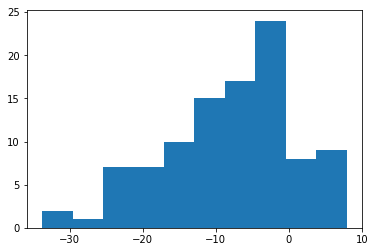

In [11]:
IF_values = torch.load("./data/mnist_s1234_1_of_6_eps10_ts100.pt")

variances = torch.mean(IF_values**2, dim=-1)

desc_idxs = torch.argsort(-variances)

print(variances[desc_idxs])

plt.hist(np.log10(variances.numpy()))

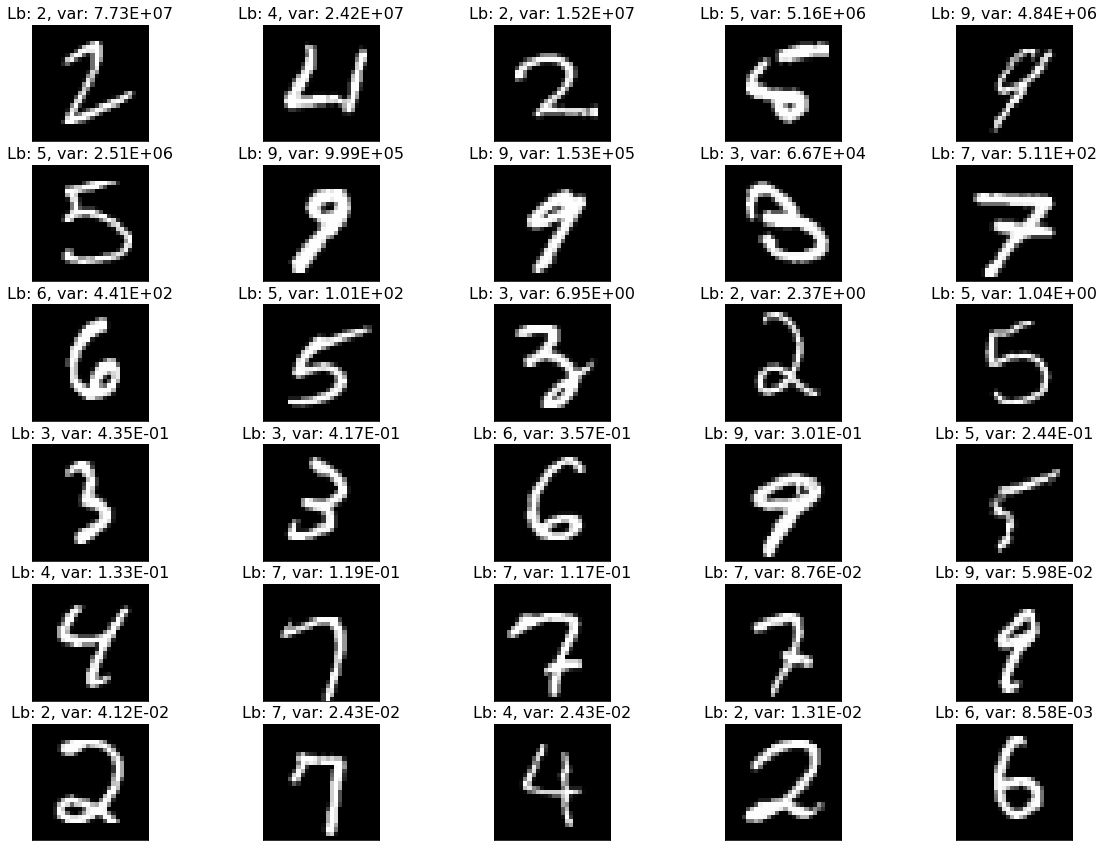

In [18]:
# Test items with highest predicted variances

test_subset = Subset(mnist_test, desc_idxs)
test_subset_loader = DataLoader(test_subset, batch_size=min(30, TEST_SUBSET_SIZE))

images, labels = iter(test_subset_loader).next()
fig, axes = plt.subplots(6, 5, figsize=(20,ceil(2.5*6)))
for idx in range(min(30, TEST_SUBSET_SIZE)):
    i, j = idx // 5, idx % 5
    axes[i][j].set_xticks([]); axes[i][j].set_yticks([])
    axes[i][j].imshow(images[idx].squeeze(0).numpy(), cmap='gray')
    axes[i][j].set_title(f"Lb: {labels[idx].item()}, var: {variances[desc_idxs[idx]]:.2E}", fontsize=16)
plt.show()

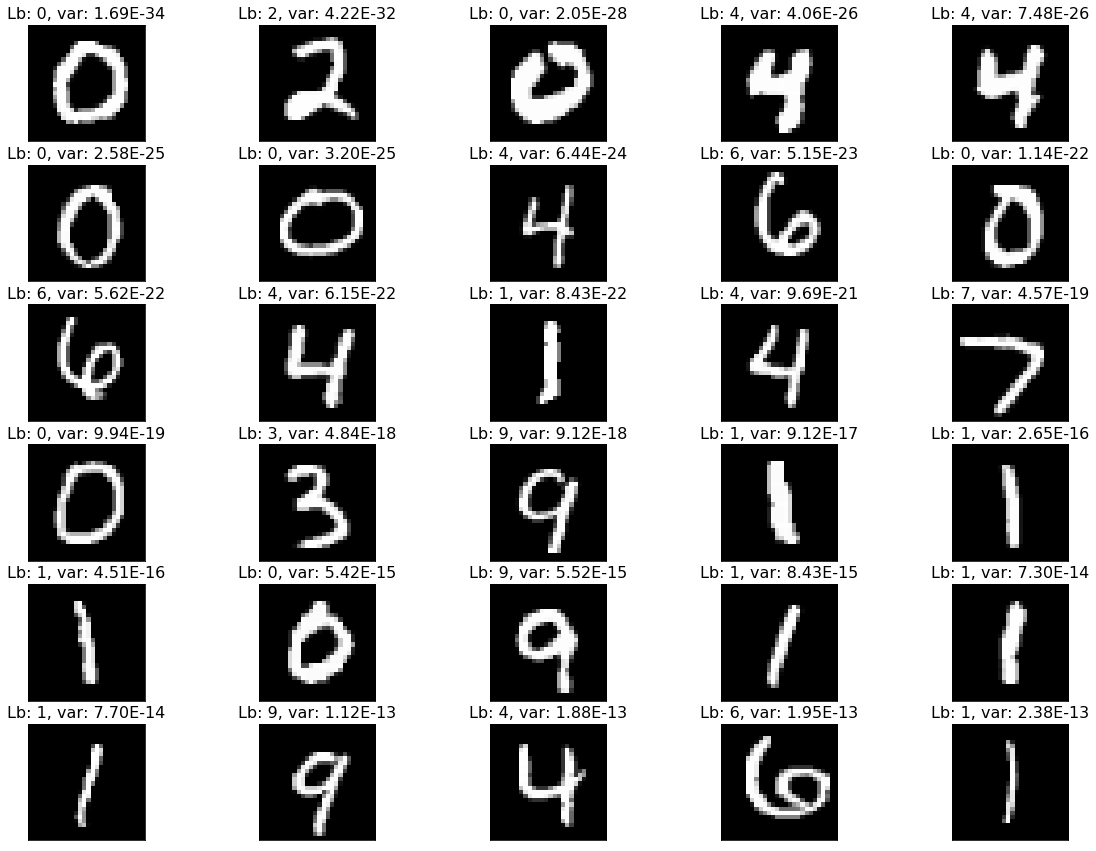

In [17]:
# Test items with lowest predicted variances

incr_idxs = desc_idxs.numpy()[::-1]
test_subset = Subset(mnist_test, incr_idxs)
test_subset_loader = DataLoader(test_subset, batch_size=min(30, TEST_SUBSET_SIZE))

images, labels = iter(test_subset_loader).next()
fig, axes = plt.subplots(6, 5, figsize=(20,ceil(2.5*6)))
for idx in range(min(30, TEST_SUBSET_SIZE)):
    i, j = idx // 5, idx % 5
    axes[i][j].set_xticks([]); axes[i][j].set_yticks([])
    axes[i][j].imshow(images[idx].squeeze(0).numpy(), cmap='gray')
    axes[i][j].set_title(f"Lb: {labels[idx].item()}, var: {variances[incr_idxs[idx]]:.2E}", fontsize=16)
plt.show()

//miniconda3/envs/lmc/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


(array([14., 25., 26., 13., 13.,  3.,  1.,  2.,  1.,  1.]),
 array([ 4.70294639,  8.83418257, 12.96541876, 17.09665494, 21.22789113,
        25.35912731, 29.4903635 , 33.62159968, 37.75283586, 41.88407205,
        46.01530823]),
 <a list of 10 Patch objects>)

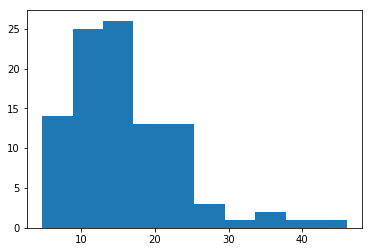

In [42]:
variances = np.zeros([NUM_SPLITS, TEST_SUBSET_SIZE])

for it in range(NUM_SPLITS):
    IF_values = torch.load(f"./data/mnist_s1234_{it+1}_of_{NUM_SPLITS}_eps{NUM_EPOCHS}_ts{TEST_SUBSET_SIZE}.pt")
    var = torch.mean(IF_values**2, dim=-1)
    variances[it] = var.numpy()
    
folds = np.max(variances, axis=0) / np.min(variances, axis=0)

plt.hist(np.log10(folds[np.isfinite(folds)]))